In [ ]:
!pip install pmdarima

In [86]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

In [20]:
## For data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
## For plotting
import matplotlib.pyplot as plt
## For Arima
import pmdarima
import statsmodels.tsa.api as smt
## For Lstm
from tensorflow.keras import models, layers, preprocessing as kprocessing
## For Prophet
from fbprophet import Prophet

In [15]:
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [46]:
dtf = pd.read_excel('data_20y_v13.xlsx')
dtf.head()

,id,version_id,itemplan_id,bi_brm,ra_rm,ei_erm,ei_elc,ei_eoh,ic_dlfc,ic_ohdfe,ic_ohdfd,ic_dlvc,ic_ohdvc,ic_idlc,ic_idohc,proq,proamt_unit,ic_arm,uc_srw,uc_dlc,uc_idlc,uc_idohc,uc_dohc
0,1,200001,3,17415549,0,46821054,0,0,5490412,280799,869822,0,2503700,930183,921941,2880,26470,81450058,52044552,5490412,930183,921941,2784499
1,2,200001,2,1526791,0,143292124,0,0,33871013,1732282,5366038,0,15445629,4334581,4296172,16639,21350,392674579,250909246,33871013,4334581,4296172,17177911
2,3,200001,1,130425628,0,142482613,0,0,2957785,151271,468589,0,1348789,387382,383949,1453,21850,33396537,21339553,2957785,387382,383949,1500060
3,4,200002,3,17413728,0,46824488,0,0,5490445,280798,869734,0,2503925,930100,921899,2880,26472,81193250,51881068,5490445,930100,921899,2784723
4,5,200002,2,1526579,0,143283554,0,0,33871697,1732316,5366085,0,15444518,4334860,4296863,16638,21348,391416771,250073131,33871697,4334860,4296863,17176834


In [100]:
#독립변수 3 항목 - 고정비, 변동비, 재료비 -> 종속변수 1 항목 - 매출액
dtf['y'] = dtf['proq'] * dtf['proamt_unit'] # 매출액
dtf['x1'] = dtf['ic_dlvc'] + dtf['ic_ohdvc'] + dtf['ic_idlc'] + dtf['ic_idohc'] #변동비4개/
dtf['x2'] =  dtf['ic_dlfc'] + dtf['ic_ohdfe'] + dtf['ic_ohdfd'] #고정비3개
dtf['x3'] = dtf['uc_srw'] # 당기 사용 재료비

df = dtf[['version_id'	,'y','itemplan_id','x1','x2','x3']]
#
df_new = df.groupby(['version_id'], as_index=False)['y','x1','x2','x3',].agg('sum')
#
from datetime import datetime

date = df_new['version_id'].astype(str)
len(date)
kdate = [datetime.strptime(d, '%Y%m') for d in date]
df_new['version_id'] = kdate
#df = pd.DataFrame({'Joined date': pd.to_datetime(df_new['version_id']),"Salary":dtf['x1']})
df_new = df_new.set_index(['version_id'])
df_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,y,x1,x2,x3
version_id,,,,
2000-01-01,463224300,30552326,51188011,324293351
2000-02-01,463176887,30552194,51188119,323222895
2000-03-01,463079531,30553722,51142137,323584299
2000-04-01,464499530,30576689,51205260,324966725
2000-05-01,462641622,30553298,51203415,324977876
...,...,...,...,...
2020-08-01,411981701,28972210,47480513,305389197
2020-09-01,408942484,28865451,47300603,304213592
2020-10-01,405887681,28757559,47123757,303056582


In [101]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [102]:
values = df_new.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_new = series_to_supervised(scaled, 1, 1)
df_new.drop(df_new.columns[[5,6,7]], axis=1, inplace=True)
df_new.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
0,0.918892,0.907171,0.929665,0.790743,0.919580
1,0.917481,0.907861,0.919980,0.803472,0.918892
2,0.938070,0.918229,0.933275,0.852160,0.917481
3,0.911132,0.907669,0.932886,0.852553,0.938070
4,0.891614,0.887098,0.945634,0.827745,0.911132


X (i-1) 3개의 독립변수에 대한 Y( = var1(i))값을 예측한다

In [90]:
len(df_new) * 0.9

225.0

In [121]:
values = df_new.values
n_train_time = len(df_new) * 0.9
train = values[:225, :]
test = values[225:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [104]:
test_x.shape

(26, 1, 4)

Epoch 1/30
19/19 - 2s - loss: 0.4079 - val_loss: 0.0750
Epoch 2/30
19/19 - 0s - loss: 0.1484 - val_loss: 0.0124
Epoch 3/30
19/19 - 0s - loss: 0.0279 - val_loss: 0.0036
Epoch 4/30
19/19 - 0s - loss: 0.0044 - val_loss: 0.0062
Epoch 5/30
19/19 - 0s - loss: 0.0038 - val_loss: 0.0044
Epoch 6/30
19/19 - 0s - loss: 0.0042 - val_loss: 0.0040
Epoch 7/30
19/19 - 0s - loss: 0.0036 - val_loss: 0.0038
Epoch 8/30
19/19 - 0s - loss: 0.0036 - val_loss: 0.0038
Epoch 9/30
19/19 - 0s - loss: 0.0035 - val_loss: 0.0035
Epoch 10/30
19/19 - 0s - loss: 0.0030 - val_loss: 0.0036
Epoch 11/30
19/19 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 12/30
19/19 - 0s - loss: 0.0033 - val_loss: 0.0035
Epoch 13/30
19/19 - 0s - loss: 0.0036 - val_loss: 0.0033
Epoch 14/30
19/19 - 0s - loss: 0.0033 - val_loss: 0.0033
Epoch 15/30
19/19 - 0s - loss: 0.0032 - val_loss: 0.0033
Epoch 16/30
19/19 - 0s - loss: 0.0037 - val_loss: 0.0031
Epoch 17/30
19/19 - 0s - loss: 0.0037 - val_loss: 0.0025
Epoch 18/30
19/19 - 0s - loss: 0.0036 - 

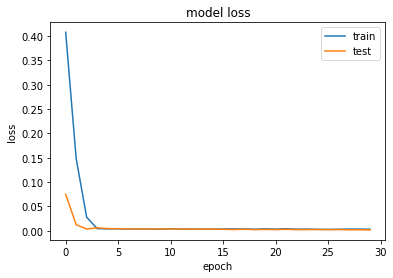

Test RMSE: 2850340.423


In [122]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_x, train_y, epochs=30, batch_size=12, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 4))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_x[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



In [147]:
model.acc

AttributeError: ignored

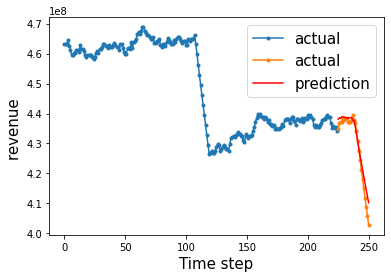

In [144]:
train_x = train_x.reshape((train_x.shape[0], 4))
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
act_y = np.concatenate((train_y, train_x[:, -3:]), axis=1)
act_y = scaler.inverse_transform(act_y)
act_y = act_y[:,0]

aa=[x for x in range(225)]
plt.plot(aa, act_y[:225], marker='.', label="actual")

aa=[x for x in range(225,251)]
#plt.plot(aa, act_y[:225], marker='.', label="actual")
plt.plot(aa, inv_y[:27], marker='.', label="actual")
plt.plot(aa, inv_yhat[:27], 'r', label="prediction")
plt.ylabel('revenue ', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()



In [75]:
inv_yhat

array([4.40527229e+08, 4.41043908e+08, 4.40814041e+08, 4.41362880e+08,
       4.41361429e+08, 4.41162106e+08, 4.41071933e+08, 4.40873304e+08,
       4.40963540e+08, 4.41024743e+08, 4.41073511e+08, 4.41076381e+08,
       4.40251743e+08, 4.40258583e+08, 4.38269378e+08, 4.35954927e+08,
       4.33640113e+08, 4.31376048e+08, 4.29115448e+08, 4.26892057e+08,
       4.24705321e+08, 4.22567973e+08, 4.20448157e+08, 4.18360036e+08,
       4.16318739e+08, 4.14291236e+08])